In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hydroeval as he
import datetime

from InterpolateHelperFunctions import *

#site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SHE (1)', 'SOL', 'SOL (1)', 'STR', 'TCU', 'TIE', 'WAN']
all_pressure_df = pd.read_csv("all_pressure.csv")

In [2]:
# site_id = "BSL"
# site_df = pd.DataFrame()
# site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
# site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
# site_df = site_df[site_df['pressure_hobo'].notna()]
# all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
# all_days = pd.DataFrame(all_days, columns=["datetime"])
# site_df = all_days.merge(site_df, on='datetime', how='left')

# #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
# test_df = get_test_df(site_df)

In [11]:
#for testing
site_names_list = ['BLI']
down_sample_list = [20]
mv_avg_width_list = [1,2,5,10,15,25,50,75,100,150,200]

Working on site: BLI
0.22900107773137546
0.43211773199684345


creating design matrix: 100%|██████████| 1490/1490 [00:00<00:00, 19548.48it/s]


NAs per column:
datetime                    0.000000
index                       0.947461
pressure_filled             0.947461
pressure_hobo               0.860888
rolling_average             0.815742
pressure_combined           0.815742
pressure_combined_filled    0.815742
dtype: float64
Attempting width: 1
Attempting width: 2
Attempting width: 5
Attempting width: 10
Attempting width: 15
Attempting width: 25
Attempting width: 50
Attempting width: 75
Attempting width: 100
Attempting width: 150
Attempting width: 200


,site,down_sampled_to,mv_avg_width,nse,pbias,rmse
0,BLI,20,1,[nan],[nan],[nan]
1,BLI,20,2,[nan],[nan],[nan]
2,BLI,20,5,[nan],[nan],[nan]
3,BLI,20,10,[nan],[nan],[nan]
4,BLI,20,15,[nan],[nan],[nan]
5,BLI,20,25,[0.5784571598060273],[0.06411027685764248],[3.481055649437326]
6,BLI,20,50,[0.5880493709453792],[0.06512191790073614],[3.441222015405103]
7,BLI,20,75,[0.5960744616663729],[0.06609605734177518],[3.407538439617473]
8,BLI,20,100,[0.6031940600608194],[0.0669541565003688],[3.3773742649419356]
9,BLI,20,150,[0.6162363449510897],[0.0683697527963537],[3.321406478030287]


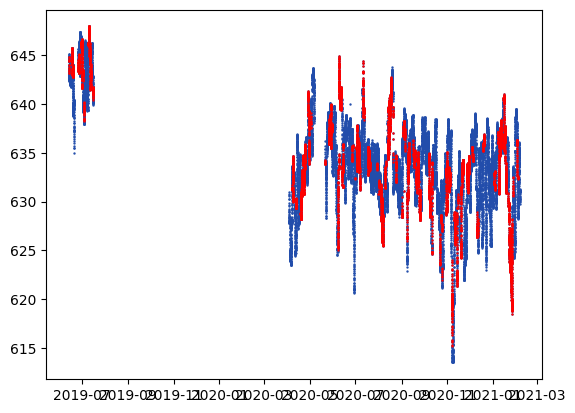

In [12]:
metrics_list = []
#iterate through each site
for site_id in site_names_list:
    print(f"Working on site: {site_id}")
    site_df = pd.DataFrame()
    
    try:
        
        site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
        site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
        site_df = site_df[site_df['pressure_hobo'].notna()]
        all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
        all_days = pd.DataFrame(all_days, columns=["datetime"])
        site_df = all_days.merge(site_df, on='datetime', how='left')

        #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
        test_df = get_test_df(site_df)

        #iterate through different potential down sample values
        for down_sample_value in down_sample_list:

            sparse_joined_df = down_sample_and_interpolate_once(test_df,all_days,down_sample_value,1,'pressure_hobo')

            #iterate through different potential moving average window widths
            for window_width in mv_avg_width_list:

                print(f"Attempting width: {window_width}")
                
                sparse_joined_df["rolling_average"] = np.nan

                # create a new column and use np.select to assign values to it using our lists as arguments
                sparse_joined_df['pressure_combined'] = sparse_joined_df.apply(combine_pressure_row, axis=1)

                # creating rolling average column that will fill in gaps left by down sampling
                sparse_joined_df["rolling_average"] = sparse_joined_df["pressure_combined"].rolling(min_periods=1, center=True, window=window_width).mean()

                #merging the actual, interpolated, and rolling average columns
                sparse_joined_df['pressure_combined_filled'] = sparse_joined_df.apply(combine_pressure_row, axis=1)

                filled_test_df = sparse_joined_df

                my_nse = he.evaluator(he.nse, filled_test_df["pressure_combined_filled"], site_df["pressure_hobo"])
                my_pbias = he.evaluator(he.pbias, filled_test_df["pressure_combined_filled"], site_df["pressure_hobo"])
                my_rmse = he.evaluator(he.rmse, filled_test_df["pressure_combined_filled"], site_df["pressure_hobo"])
                
                #add metrics and identifiers to a list of dictionaries
                metrics_dict = (site_id, down_sample_value, window_width, my_nse, my_pbias, my_rmse)
                metrics_list.append(metrics_dict)

                exec(f'{site_id}_{window_width}_filled_df = filled_test_df.copy()')

    except Exception as e: print(e)

#transform metrics list into dataframe
metrics_df = pd.DataFrame(metrics_list, columns=["site","down_sampled_to", "mv_avg_width","nse","pbias","rmse"])
metrics_df

datetime                    0.000000
index                       0.947461
pressure_filled             0.947461
pressure_hobo               0.860888
rolling_average             0.000000
pressure_combined           0.815742
pressure_combined_filled    0.000000
dtype: float64


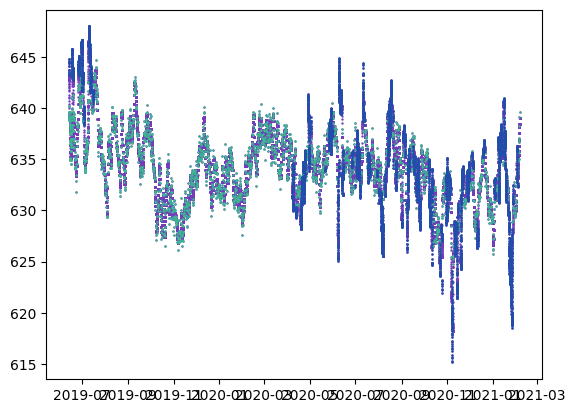

In [20]:
print(BLI_100_filled_df.isna().sum()/BLI_100_filled_df.shape[0])

plt.scatter(x = "datetime", y = "pressure_combined_filled",data=BLI_100_filled_df, label="Completely Filled Data", s = .5, color="#723cba")
plt.scatter(x = "datetime", y = "pressure_filled",data=BLI_100_filled_df, label="Sparse Filled Data", s = .5, color="#3bb892")
plt.scatter(x = "datetime", y = "pressure_hobo",data=BLI_100_filled_df, label="Actual Data", s = .5, color="#224dab")

# left = datetime.date(2019, 8, 1)
# right = datetime.date(2019, 8, 2)
# # # Format the date into months & days
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y')) 
# # Changes x-axis range
# plt.gca().set_xbound(left, right)
# plt.legend()
# plt.show()

In [14]:
#fixing type for the metrics columns
metrics_df['nse'] = pd.to_numeric(metrics_df['nse'].str[0])
metrics_df['pbias'] = pd.to_numeric(metrics_df['pbias'].str[0])
metrics_df['rmse'] = pd.to_numeric(metrics_df['rmse'].str[0])

#the closer to 0 the better for percent bias, so taking the absolute value and then finding the minimum works here
metrics_df['pbias_abs'] = metrics_df['pbias'].abs()

In [15]:
#making a dataframe for each metric that shows which parameters resulted in the best score for each site
nse_maxs_df = metrics_df.loc[metrics_df.groupby('site')['nse'].idxmax().values]
pbias_mins_df = metrics_df.loc[metrics_df.groupby('site')['pbias_abs'].idxmin().values]
rmse_mins_df = metrics_df.loc[metrics_df.groupby('site')['rmse'].idxmin().values]


In [16]:
nse_maxs_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
10,BLI,20,200,0.627627,0.069312,3.271741,0.069312


In [17]:
rmse_mins_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
10,BLI,20,200,0.627627,0.069312,3.271741,0.069312


In [18]:
pbias_mins_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
5,BLI,20,25,0.578457,0.06411,3.481056,0.06411
